In [1]:
#install kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saumyadadu","key":"41d77c120360e7e2b068163374f6dae8"}\n\n'}

In [3]:
#creating a kaggle folder
!mkdir ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                              title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                           Netflix Movies and TV Shows                        1MB  2024-04-10 09:48:38           7782        154  1.0              
aniketmahajan1104/indian-cities-electricity-consumption-2017-19  Indian Cities Electricity Consumption 2017-19      2KB  2024-04-24 09:34:25            646         23  1.0              
jaceprater/smokers-health-data                                   Smoker's Health Data                              29KB  2024-04-20 17:09:38           1526         25  1.0              
mexwell/heart-disease-dataset                                    🫀 Hea

In [7]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [11:28<00:00, 28.0MB/s]
100% 14.9G/14.9G [11:28<00:00, 23.2MB/s]


In [8]:
!unzip plant-pathology-2021-fgvc8.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/e00c97b2de4749ce.jpg  
  inflating: train_images/e00df890cfe62736.jpg  
  inflating: train_images/e00ed0bf43a87f25.jpg  
  inflating: train_images/e00f759d65d52887.jpg  
  inflating: train_images/e00f934d9e50ad5b.jpg  
  inflating: train_images/e00fce341cb63da5.jpg  
  inflating: train_images/e010c7c35ecf3d1c.jpg  
  inflating: train_images/e01112939f783fec.jpg  
  inflating: train_images/e01592da4d71b8be.jpg  
  inflating: train_images/e0189acaf8cf80fd.jpg  
  inflating: train_images/e0189e4999bdd0fa.jpg  
  inflating: train_images/e01ae16d4a759cb5.jpg  
  inflating: train_images/e01dc39ccb2b4ccb.jpg  
  inflating: train_images/e01e42d90c66f3f3.jpg  
  inflating: train_images/e01e870bec65f40f.jpg  
  inflating: train_images/e01f17e0187fb80f.jpg  
  inflating: train_images/e01f503cb752e6c5.jpg  
  inflating: train_images/e024b69a784e9fc3.jpg  
  inflating: train_images/e026b4c23c9fcfc4.jpg  
  inflating: train

In [9]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import random
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [10]:
train_image_path = '/content/train_images'
test_image_path = '/content/test_images'
train_df_path = '/content/train.csv'
test_df_path = '/content/sample_submission.csv'

In [11]:
df_train = pd.read_csv(train_df_path)
df_test=pd.read_csv(test_df_path)

In [12]:
df_test

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [13]:
df_train.labels.value_counts()

labels
scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: count, dtype: int64

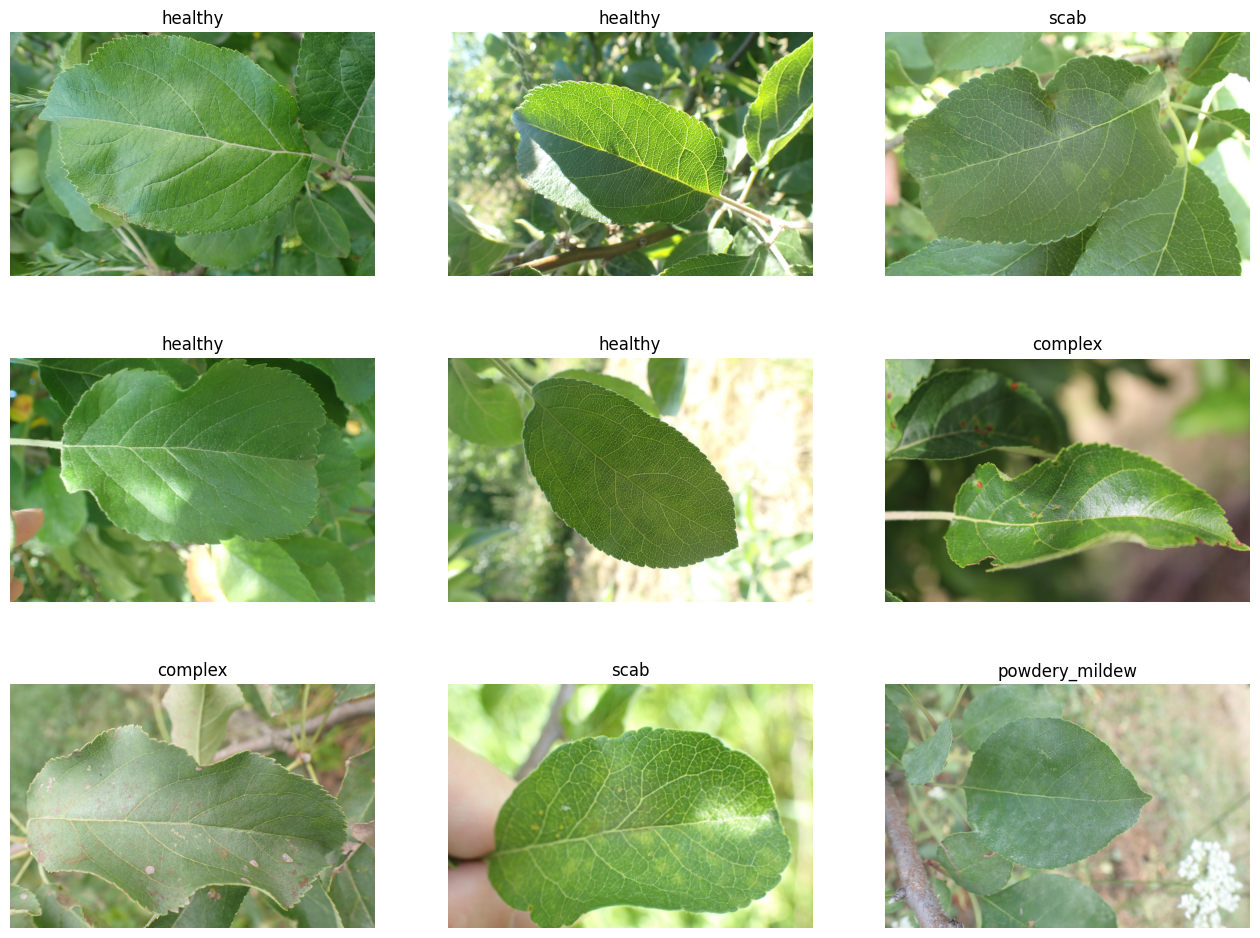

In [14]:
def batch_visualize(df,batch_size,path):
    sample_df = df_train.sample(9)
    image_names = sample_df["image"].values
    labels = sample_df["labels"].values
    plt.figure(figsize=(16, 12))

    for image_ind, (image_name, label) in enumerate(zip(image_names, labels)):
        plt.subplot(3, 3, image_ind + 1)
        image = cv2.imread(os.path.join(path, image_name))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    plt.show()

batch_visualize(df_train,9,train_image_path)


In [15]:
HEIGHT = 128
WIDTH=128
SEED = 45
BATCH_SIZE= 64

train_datagen = ImageDataGenerator(rescale = 1/255.,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    zoom_range = 0.2,
    shear_range = 0.2,
    vertical_flip = False)

train_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "training",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

validation_dataset = train_datagen.flow_from_dataframe(
    df_train,
    directory = train_image_path,
    x_col = "image",
    y_col = "labels",
    target_size = (HEIGHT,WIDTH),
    class_mode='categorical',
    batch_size = BATCH_SIZE,
    subset = "validation",
    shuffle = True,
    seed = SEED,
    validate_filenames = False
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)
INPUT_SIZE = (HEIGHT,WIDTH,3)
test_dataset=test_datagen.flow_from_dataframe(
    df_test,
    directory=test_image_path,
    x_col='image',
    y_col=None,
    class_mode=None,
    target_size=INPUT_SIZE[:2]
)


Found 14906 non-validated image filenames belonging to 12 classes.
Found 3726 non-validated image filenames belonging to 12 classes.
Found 3 validated image filenames.


In [16]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',padding='same',input_shape=(HEIGHT,WIDTH,3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(12,activation='softmax'))

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [18]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [19]:
import tensorflow_hub as hub
efficientnet_model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/feature-vector/1", trainable=False)
])

combined_model = tf.keras.Sequential([
    efficientnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(12, activation='softmax')
])


precision = tf.keras.metrics.Precision()


combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy', precision])


combined_model_history = combined_model.fit_generator(train_dataset,
                                                      validation_data=validation_dataset,
                                                      epochs=25,
                                                      steps_per_epoch=train_dataset.samples // BATCH_SIZE,
                                                      validation_steps=validation_dataset.samples // BATCH_SIZE,
                                                      callbacks=[cp_callback])


232/232 [==============================] - ETA: 0s - loss: 1.5839 - accuracy: 0.4571 - precision: 0.6714
Epoch 1: saving model to training_1/cp.ckpt
232/232 [==============================] - 2057s 9s/step - loss: 1.5839 - accuracy: 0.4571 - precision: 0.6714 - val_loss: 1.2710 - val_accuracy: 0.5800 - val_precision: 0.7702


In [21]:
train_dataset.class_indices.items()

dict_items([('complex', 0), ('frog_eye_leaf_spot', 1), ('frog_eye_leaf_spot complex', 2), ('healthy', 3), ('powdery_mildew', 4), ('powdery_mildew complex', 5), ('rust', 6), ('rust complex', 7), ('rust frog_eye_leaf_spot', 8), ('scab', 9), ('scab frog_eye_leaf_spot', 10), ('scab frog_eye_leaf_spot complex', 11)])

In [22]:
preds = model.predict(test_dataset)
print(preds)

1/1 [==============================] - 1s 734ms/step
[[0.07791289 0.07006801 0.065859   0.10070348 0.0830447  0.07651491
  0.09485578 0.10122013 0.08642607 0.0736034  0.07492243 0.09486911]
 [0.07657354 0.06812962 0.07579941 0.09914366 0.07984143 0.08649515
  0.10161816 0.09817158 0.07761151 0.07589528 0.07496504 0.08575565]
 [0.07459716 0.07037678 0.06960199 0.09580659 0.08467013 0.0779505
  0.10179611 0.09903922 0.08595372 0.07306422 0.07392943 0.09321417]]


In [23]:
preds_disease_ind=np.argmax(preds, axis=-1)

In [24]:
preds_disease_ind

array([7, 6, 6])